入念に整理してこちらを公開できるようにしよう。

今、A（施策）のYへの効果を推定したいとする。
しかし、AとY両方に相関するUという変数のせいで、A,Y間の相関を因果として解釈できなくなってしまっている。

今回はUが観測できない時に、その交絡を調整しないでこの因果関係を推定する手法としてIV法というものを紹介する。

以下考える状況のDAGの一例
<img src="../img/IV.png">

## 2SLS


$y = \mu + \alpha x + \epsilon$<br>
$x = \gamma + \pi z + v$

Regress y on z, then we get,
$\hat{\beta\pi} = \frac{\sum_i(z_i - \bar{z})(y_i - \bar{y})}{\sum_i(z_i - \bar{z})^2}$

This estimator is unbiased,
$E[\hat{\beta\pi}] = E[\frac{\sum_i(z_i - \bar{z})(y_i - \bar{y})}{\sum_i(z_i - \bar{z})^2}] = $
$\beta \pi + E[\frac{\sum_i(z_i - \bar{z})(\beta v + \epsilon)}{\sum_i(z_i - \bar{z})^2}] = \beta \pi$<br>
(The last equation is due to $Z \!\perp\!\!\!\perp \epsilon, v$)

Regress x on z, then we get,
$\hat{\pi} = \frac{\sum_i(z_i - \bar{z})(x_i - \bar{x})}{\sum_i(z_i - \bar{z})^2}$<br>

This estimator is also unbiased,
$E[\hat{\pi}] = E[\frac{\sum_i(z_i - \bar{z})(x_i - \bar{x})}{\sum_i(z_i - \bar{z})^2}] = $
$\pi + E[\frac{\sum_i(z_i - \bar{z})v}{\sum_i(z_i - \bar{z})^2}] = \pi$<br>
(The last equation is due to $Z \!\perp\!\!\!\perp v$)


Therefore we can get the estimated parameter $\hat{\beta}$, by divide $\hat{\beta\pi}$ by $\hat{\pi}$

今、$\alpha, \beta$が各個人で不変の時を仮定している。

- ２変数のときを考えると、これはつまり、
    - $\alpha$:Treatment群に配置する事で実際に処置を受ける確率
    - $\beta$:処置を受けた事で状態が改善する確率
- と解釈する事ができる。

**もし、各個人で、実際に配置された時に、以下のように4つの行動パターンをとるグループがあるとしたら？**

- never-taker(N):配置されようがされまいが、処置を受けない
- complier(C):配置されるかぎりに置いて処置を受けない
- Always-taker(A):配置されようがされまいが、処置を受ける
- defier(D):配置されたら処置を受けず、配置されない場合処置を受ける。

--|X(Z=1)=1|X(Z=1)=0
--|--|--
X(Z=0)=1|AlwaysTaker|Defier
X(Z=1)=0|Complier|Never-taker

--|X=1|X=0
--|--|--
Z=1|A+C|N+D
Z=0|A+D|N+C

今回はこのケースで上の古典的操作変数法が正しく$\bar{\beta}$を推定できなくなる事を示します。

In [1]:
# curse of dimensionality

In [2]:
import numpy as np

In [3]:
np.array([1,1,1,1,1])

array([1, 1, 1, 1, 1])

In [4]:
# uniform in the unit ball
p=10
samples = np.random.uniform(low=0.0, high=1, size=100*p)
samples = samples.reshape((-1, p))

In [5]:
np.sqrt(np.sum(samples**2, axis=1))

array([1.94356451, 1.86585247, 1.97864425, 1.63033441, 2.23159571,
       1.27777983, 1.62293205, 1.69092052, 2.26526842, 1.59404419,
       1.93546537, 1.86364451, 2.13036793, 1.66061744, 1.80840767,
       1.88159676, 2.05792075, 2.00470037, 1.28124445, 2.03732628,
       1.49516192, 1.20701175, 2.02637955, 1.7999635 , 1.73024148,
       2.15158793, 1.61913832, 1.60771406, 1.62844366, 1.78122389,
       1.35465049, 1.88885292, 1.96748484, 2.14765763, 1.94887195,
       1.16298172, 1.69180419, 2.12323885, 1.6953017 , 2.03438628,
       2.31556511, 1.24742403, 1.68165494, 1.64255736, 1.84733171,
       2.30435159, 2.02320704, 1.89508677, 1.88339444, 2.07684509,
       1.77945009, 1.99604497, 1.89862615, 1.34712525, 2.04238569,
       1.69208524, 1.89114525, 1.35647366, 1.18118684, 1.4258711 ,
       1.97571858, 1.97160589, 1.8196349 , 1.10827331, 1.99491559,
       1.77207889, 2.21539839, 1.98850587, 1.70498121, 2.18594542,
       1.86678729, 1.56652916, 1.89227538, 1.92245475, 2.04800

In [6]:
def test(iterable, m=3):
    print(iterable, m)
    return iterable + m

a = [1,2,3,4,5,6]

list(map(test, a, {61}))

1 61


[62]

In [118]:
Sigma


array([[ 1. , -0.7,  0.4],
       [-0.7,  1. ,  0. ],
       [ 0.4,  0. ,  1. ]])

In [117]:
Sigma = np.eye(3)
Sigma[1, 0] = -0.7
Sigma[0, 1] = -0.7
Sigma[2, 0] = 0.4
Sigma[0, 2] = 0.4
d = np.random.multivariate_normal([0.5, 1.5, 20.0], Sigma, size=10000)

In [120]:
d.shape

(10000, 3)

In [121]:
e = np.random.randn(len(d))

In [122]:
X = d[:, 0]
u = d[:, 1]
Z = d[:, 2]

In [150]:
y = X*2 + 6*u + e

In [151]:
import seaborn as sns

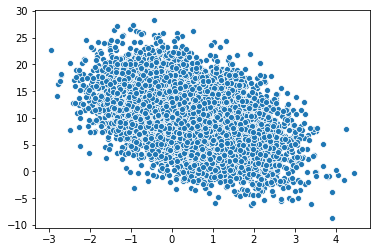

In [152]:
sns.scatterplot(x=X, y=y)

In [153]:
np.corrcoef([X, y, Z, U])

array([[ 1.        , -0.4456496 ,  0.40693922,  0.02750153],
       [-0.4456496 ,  1.        ,  0.16811764, -0.00920544],
       [ 0.40693922,  0.16811764,  1.        ,  0.01080933],
       [ 0.02750153, -0.00920544,  0.01080933,  1.        ]])

In [154]:
np.cov(Z, U)[1, 0]

0.010799578091368672

In [155]:
def ols(x, y):
    denom = np.mean((x - np.mean(x))**2)
    nomi = np.cov(X, y)[1, 0]
    return nomi/denom

In [161]:
ols(X, y), ols(X, y - 6*u)

(-2.183484445226879, 1.9984924277824139)

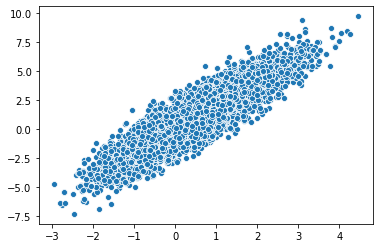

In [160]:
sns.scatterplot(x=X, y=y-6*u)

In [158]:
def IV(x, y, z):
    denom = np.cov(X, z)[1, 0]
    nomi = np.cov(z, y)[1, 0]
    return nomi/denom

In [159]:
IV(X, y, Z)

2.0239365610687368

## OLS推定量ではマイナスになっていたが、IV法を利用すると真のモデルと整合的な推定値を求めることができた。

- U関係なく動くZの変動を利用し、Zと相関するXの変動からYの変動を説明するということ。
- IVの式を確認すると、$\displaystyle \frac{Cov(Z, Y)}{Cov(Z, X)}$となっていることがわかる。

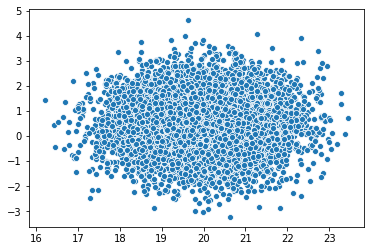

In [162]:
sns.scatterplot(x=Z, y=U)

In [ ]:
## Weak Instrumentのケースを紹介する（TBD）

In [163]:
# Sigma = np.eye(4)
# Sigma[1, 0] = Sigma[0, 1] = 0.4
# Sigma[2, 0] = Sigma[0, 2] = 0.7
# Sigma[0, 3] = 0.5;Sigma[3, 0] = 0.5;Sigma[1, 3] = 0.5;Sigma[3, 1] = 0.5
# # X, y, IV, U
# data = np.random.multivariate_normal([0.5, 3, 0.5, 0.5], Sigma, size=10000)
# X = data[:, 0]
# y = data[:, 1]
# Z = data[:, 2]
# U = data[:,3]
# y[X>0].mean(), y[X<0].mean()
# np.corrcoef(y, (U> 0)*1, )